# (Advanced) Forecasting the thermal resistance 

Along with the Physics calculations, if we need to predict the values of thermal resistance for future timesteps, based on trend or other factors, we can quickly build a model which will forecast the thermal resistance, based on recent history and it can be used to monitor the performance of the heat exchanger and using predictions, we can detect any upcoming issues or problems in the system.

## Authentication

Create a client to communicate with the cognite data platform (CDF)

In [1]:
# Put down your name
YOUR_NAME = "Jack"

In [2]:
#from cognite.client import CogniteClient
from msal import PublicClientApplication
from cognite.experimental import CogniteClient


# Contact Project Administrator to get these
TENANT_ID="48d5043c-cf70-4c49-881c-c638f5796997"
CLIENT_ID="fab52bb5-9de2-4f9e-aefa-712da4b5fe00"
CDF_CLUSTER="westeurope-1"
COGNITE_PROJECT="ds-basics"

SCOPES = [f"https://{CDF_CLUSTER}.cognitedata.com/.default"]

AUTHORITY_HOST_URI = "https://login.microsoftonline.com"
AUTHORITY_URI = AUTHORITY_HOST_URI + "/" + TENANT_ID
PORT = 53000

app = PublicClientApplication(client_id=CLIENT_ID, authority=AUTHORITY_URI)
creds = app.acquire_token_interactive(scopes=SCOPES, port=PORT)

TOKEN_URL = f"https://login.microsoftonline.com/{TENANT_ID}/oauth2/v2.0/token"

client = CogniteClient(
    token_url=creds["id_token_claims"]["iss"],
    token=creds["access_token"],
    token_client_id=creds["id_token_claims"]["aud"],
    project=COGNITE_PROJECT,
    base_url=f"https://{CDF_CLUSTER}.cognitedata.com",
    client_name="cognite-client-interactive"
    )

Opening in existing browser session.


libva error: vaGetDriverNameByIndex() failed with unknown libva error, driver_name = (null)


## Machine Learning to Forecast the thermal resistance

Along with the Physics calculations, if we need to predict the values of thermal resistance for future timesteps, based on trend or other factors, we can quickly build a model which will forecast the thermal resistance, based on recent history and it can be used to monitor the Performance of the Heat exchanger and using predictions, we can detect any upcoming issues or problems in the system.

First install the library we'll use for forecasting

In [5]:
%pip install -q Prophet

You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


Retrieve the data required for the Heat Exchanger

In [6]:
column_names = ["T_cold_IN","T_cold_OUT","T_hot_IN","T_hot_OUT","Flow_cold","Flow_hot"]
ts_exids = ['pi:163657','pi:163658','pi:160887','pi:191092','pi:163374','pi:160184']

import datetime
from datetime import timedelta
start_date = datetime.datetime(2018, 8, 1)
end_date = start_date + timedelta(days=30)

df = client.datapoints.retrieve_dataframe(external_id=ts_exids,
                                                     aggregates=['average'],
                                                     granularity='1h',
                                                     start=start_date,
                                                     end=end_date,
                                                     include_aggregate_name=False
                                                     )
df.fillna(method="ffill", inplace=True)
df.columns = column_names
df.head()

,T_cold_IN,T_cold_OUT,T_hot_IN,T_hot_OUT,Flow_cold,Flow_hot
2018-08-01 00:00:00,16.784609,108.846831,126.606315,35.017099,101.142261,164362.175208
2018-08-01 01:00:00,16.802548,109.051995,126.506479,34.962238,99.901727,163875.622135
2018-08-01 02:00:00,16.796142,108.922387,126.460531,35.020834,100.574942,164397.399993
2018-08-01 03:00:00,16.793055,109.171361,126.621469,34.990039,99.346718,163128.807848
2018-08-01 04:00:00,16.800542,109.132157,126.479283,34.996638,99.440407,163634.013288


In [7]:
from tools import thermal_resistance

# Calculate the thermal resistance
df['TR'] = df.apply(lambda x:thermal_resistance(x),axis=1)

Now, let's format the data suitable for Prophet functions

In [8]:
df2 = df.copy()[['TR']].reset_index()
df2 = df2.rename(columns={'index':"ds",'TR':"y"})

df2.head()

,ds,y
0,2018-08-01 00:00:00,3.984586e-07
1,2018-08-01 01:00:00,3.956120e-07
2,2018-08-01 02:00:00,3.964584e-07
3,2018-08-01 03:00:00,3.974058e-07
4,2018-08-01 04:00:00,3.956495e-07


In [9]:
df.shape

(720, 7)

In [10]:
from prophet import Prophet

/home/keepfloyding/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [11]:
m = Prophet()
m.fit(df2)

12:20:15 - cmdstanpy - INFO - Chain [1] start processing
12:20:15 - cmdstanpy - INFO - Chain [1] done processing


### Forecast for next 15 days

Let's add 10% increase from the historical mean as the threshold for monitoring

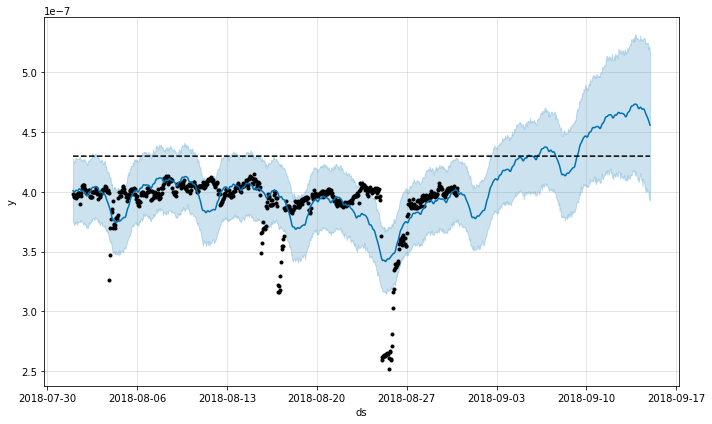

In [12]:
future = m.make_future_dataframe(periods=24*15, freq='H')
future['cap'] = 1.1*df['TR'].mean() #
fcst = m.predict(future)
fig = m.plot(fcst)

It shows that as per current trend based on last few weeks, data, it will cross the threshold very soon. This information can be utilized by the maintenance department or the operations.

Next, we can create the cognite function to run this model daily and save the forecasts in CDF for monitoring purposes.

## Running ML predictions with cognite functions

Add the below code the the handler.py file. Additionally, we need to create a requirements.txt file to add the Prophet library as dependency to be installed.

In [14]:
from cognite.client.data_classes import TimeSeries
from math import log
import datetime
from datetime import timedelta
from prophet import Prophet

def thermal_resistance(x):
    '''Function to calculate Thermal Resistance'''
    # Some constants like Correction factor, Area and Cp values
    F = 0.8
    A = 1.0
    Cp_hot = 2.4
    # Calculate the cross temperature differences
    x['dT1'] = x['T_hot_IN'] - x['T_cold_OUT']
    x['dT2'] = x['T_hot_OUT'] - x['T_cold_IN']
    # Calculate the numerator and denominator for the thermal resistance calculation
    temp1 = A*F*(x['dT1']-x['dT2'])/log(x['dT1']/x['dT2'])
    temp2 = x['Flow_hot']*Cp_hot*(x['T_hot_IN']-x['T_hot_OUT'])
    tr = temp1/temp2
    return tr

def thermal_resistance_forecast(df):
    '''Function to forecast the Thermal Resistance'''
    df2 = df.copy()[['TR']].reset_index()
    df2 = df2.rename(columns={'index':"ds",'TR':"y"})
    m = Prophet()
    m.fit(df2)
    future = m.make_future_dataframe(periods=24*15, freq='H')
    future['cap'] = 1.1*df['TR'].mean() #
    fcst = m.predict(future)
    fcst_df = fcst[['ds','yhat']].set_index('ds')
    fcst_df.columns = ['TR']
    return fcst_df

def create_and_save_time_series_data(client,data,ts_external_id):
    '''Function to create the time series and save the data'''
    asset_id = 7640884189698369 # 23-HA-9114 Asset
    cdf_ts = client.time_series.retrieve(external_id=ts_external_id)
    if cdf_ts is None:
        ts = TimeSeries(external_id=ts_external_id,name=ts_external_id, asset_id = asset_id, unit = 'm2K/W')
        client.time_series.create(ts)
        print("Created time series")
    else:
        print("Existing Time Series")
        
    dps = []
    for index, r in data.iterrows():
        dps= dps+[{"timestamp": r.name, "value": r['TR']}]
        client.datapoints.insert(datapoints = dps,external_id = ts_external_id)


def handle(client,data=None, secrets=None, function_call_info=None):
    """Handler Function to be Run/Deployed
    Args:
        client : Cognite Client (not needed, it's availble to it, when deployed)
        data : data needed by function
        secrets : Any secrets it needs
        function_call_info : any other information about function

    Returns:
        response : response or result from the function 
    """
    ts_exids = ['pi:163657','pi:163658','pi:160887','pi:191092','pi:163374','pi:160184']
    column_names = ["T_cold_IN","T_cold_OUT","T_hot_IN","T_hot_OUT","Flow_cold","Flow_hot"]
    # Retrieve the data
    start_date = datetime.datetime(2018, 8, 1)
    end_date = start_date + timedelta(days=30)
    df = client.datapoints.retrieve_dataframe(external_id=ts_exids,
                                                        aggregates=['average'],
                                                        granularity='1h',
                                                        start=start_date,
                                                        end=end_date,
                                                        include_aggregate_name=False
                                                        )
    df.fillna(method="ffill", inplace=True)
    df.columns = column_names
    # Calculate the Thermal resistance
    df['TR'] = df.apply(lambda x:thermal_resistance(x),axis=1)
    # Forecast the Thermal resistance
    fcst_df = thermal_resistance_forecast(df)
    # Save the Results as time series
    create_and_save_time_series_data(client,df[['TR']],"hx_thermal_resistance")
    create_and_save_time_series_data(client,fcst_df[['TR']],"hx_thermal_resistance_forecast")
    # Return the result as json
    result = df[['TR']].to_json()
    return result

We can create a new folder and save the updated handler.py & requirements.txt file there. There is already a folder in solutions if you would like to use that

In [ ]:
# ! mkdir ../hx-thermal-resistance-forecast

In [3]:
function_external_id = f"fthermal-perf-forecast-{YOUR_NAME}"

function = client.functions.create(
    name="Thermal Performance Forecasting Function",
    external_id=function_external_id,
    folder="../solutions/hx-thermal-resistance-forecast/",
    description="Function to Calculate & Forecast Thermal Performance of Discharge Coolers",
    owner="Choukha Ram"
    )
# Note : if this cell is giving you errors :
# Just restart the notebook, create the cognite client and run this cell again.

/home/keepfloyding/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Importing plotly failed. Interactive plots will not work.


In [4]:
from function_tools import status_check

status_check(function)

Function is successfully deployed. Wait time: 300 seconds.


In [5]:
# Call your function

call = function.call()
call

,value
id,1270349217354382
start_time,1659612741050
end_time,1659612776374
status,Completed
function_id,1158349233356289


<AxesSubplot:>

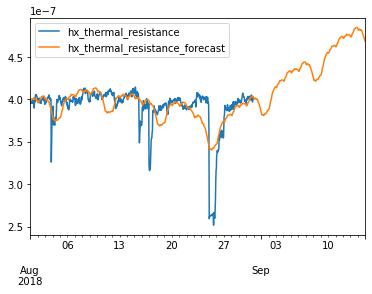

In [9]:
# Check if time series has been written back to and plot both the value and the forecast
import datetime as datetime

df=client.datapoints.retrieve(external_id = ["hx_thermal_resistance","hx_thermal_resistance_forecast"], start=datetime.datetime(2018, 8, 1), end=datetime.datetime(2018, 10, 1)).to_pandas()
df.plot()

## Cleanup

You can delete the created/deployed function using Code or UI. This will also delete the schedules along with them.

In [8]:
client.functions.delete(id=function.id)